# Cognitive Modeling - Assignment 3
Yorick Juffer \
s1993623

## Libraries

In [1]:
import math
import random

from model import Model
from dmchunk import Chunk

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Pulses
These are functions found on brightspace from week 2.

In [2]:
t_0 = 0.011
a = 1.1
b = 0.015
add_noise = True

def noise(s):
    rand = random.uniform(0.001, 0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = t_0, a = a, b = b, add_noise = add_noise):  
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

def pulses_to_time(pulses, t_0 = t_0, a = a, b = b, add_noise = add_noise):
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

## Motivation
This is an extract of the models found on brightspace in week 5 named Boksem.ipynb.  

In [3]:
class ModelWithMotivation(Model):
    da = 0.5  # distraction activation
    discount = 0.1 # discount due to motivation drop
    
    def discount_goal_activation(self):
        self.ga -= self.discount
        
    def __str__(self):
        return "\n=== Model ===\n" \
        "Time: " + str(self.time) + " s \n" \
        "Goal:" + str(self.goal) + "\n" \
        "DM:" + "\n".join([str(c) for c in self.dm]) + "\n" \
        "ga: " + str(self.ga) + "\n" 
    
    def distraction(self):
        return self.da + self.noise(self.s) > self.ga + self.noise(self.s)

# Experiment timing:
distraction_mean_time = 0.2 # average distraction time
distraction_variation = 0.1 # variation in distraction (uniform)
focus_loss_probability = 0.2 # probability to lose focus once prepared
focus_latency = 0.2 # if we decide to stay focussed, we focus for this amount of time


def distraction_time():
    return random.uniform(distraction_mean_time - distraction_variation, distraction_mean_time + distraction_variation)

## Full Experiment

In [4]:
def experiment(participants):

    reward_visibility = [
        [0, 0], 
        [1, 0], 
        [1, 1], 
        [0, 1]]
    foreperiod_location = [
        [0.3, 0],
        [0.3, 1],
        [0.6, 0],
        [0.6, 1],
        [0.9, 0],
        [0.9, 1]]

    # visibility 0 = poor
    # location 0 = left
    
    recording = False
    count = 0
    for participant in range(participants):

        # prep the model, add a single instance to avoid an error with NoneType
        model = ModelWithMotivation()
        pulses = time_to_pulses(0.6)
        chunk = Chunk(name = "time" + "train", slots = {"type": "time", "value": pulses})
        model.add_encounter(chunk)
        model.time += 0.1

        # shuffle the lists
        random.shuffle(reward_visibility)
        random.shuffle(foreperiod_location)

        index_block = 0
        index_trial = 0

        for block in range(16):

            if(index_block == 4):
                random.shuffle(reward_visibility)
                index_block = 0
            
            reward = reward_visibility[index_block][0]
            visibility = reward_visibility[index_block][1]

            if(reward == 1):
                model.ga = 1.0
            
            for trial in range(30):

                if(index_trial == 6):
                    random.shuffle(foreperiod_location)
                    index_trial = 0

                foreperiod = foreperiod_location[index_trial][0]
                location = foreperiod_location[index_trial][1]
                intertrial_interval = random.uniform(0.5, 0.8)
                cue_stimulus_interval = foreperiod + intertrial_interval

                # pre stimulus
                start = model.time
                blend_pattern = Chunk(name = "foreperiod", slots = {"type": "time"})
                chunk, latency = model.retrieve_blended_trace(blend_pattern, "value")
                model.time += latency

                # assessing the motivation
                running = True
                prepared = False
                while(running):
                    if(model.time - start < cue_stimulus_interval and not model.distraction()):
                        prepared = True
                        model.time += focus_latency + 0.05
                    elif(model.time - start < cue_stimulus_interval):
                        model.time += distraction_time() + 0.1
                    elif(prepared):
                        model.time += 0.05
                        running = False
                    else:
                        model.time += 0.1
                        running = False

                # stimulus, 0.75 weight for anticipation of the stimulus.
                difference = foreperiod - pulses_to_time(chunk * 0.75)

                # estimation of stimulus arrival.
                # introduces a small bias for when visibility is high
                if (difference >= 0.075):
                    model.time += 0.075 - (0.01 * visibility)
                elif(difference <= 0):
                    model.time += 0.1
                else:
                    model.time += 0.075 + difference - (0.01 * visibility)
                
                reaction_time = model.time - start - (0.025 * visibility) - cue_stimulus_interval

                if(not recording):
                    results = np.array([[participant, block, trial, reward, visibility, foreperiod, location, reaction_time]])
                    recording = True
                else:
                    results = np.append(results, [[participant, block, trial, reward, visibility, foreperiod, location, reaction_time]], axis=0)
                
                # post stimulus
                pulses = time_to_pulses(foreperiod)
                chunk = Chunk(name = "time" + str(count), slots = {"type": "time", "value": pulses})
                model.add_encounter(chunk)
                model.time += intertrial_interval + 0.1
                
                model.discount_goal_activation()

                # simple printout to see progress.
                print("Participant: {}/{}".format(participant + 1, participants), end="\r")
                count += 1

                index_trial += 1
            index_block += 1

    return results 

## Run the Experiment

In [5]:
data = experiment(100)

## Data Analysis

### Graphing

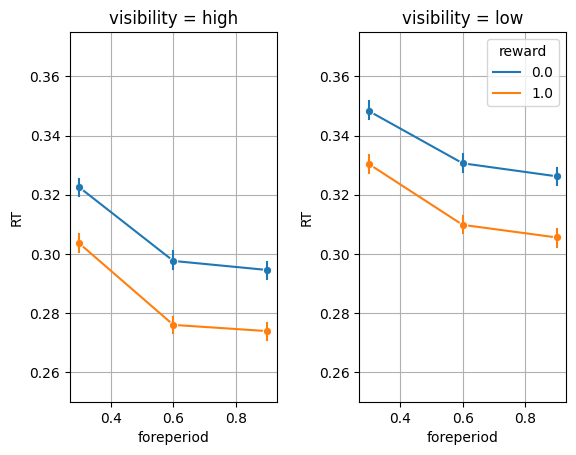

In [6]:
dataFrame = pd.DataFrame(data)
dataFrame.columns = ["participant", "block", "trial", "reward", "visibility", "foreperiod", "location", "RT"]

df1 = dataFrame[dataFrame["visibility"] == 1]
df2 = dataFrame[dataFrame["visibility"] == 0]

fig, ax = plt.subplots(1,2)
ax1 = sns.lineplot(data=df1, x="foreperiod", y="RT", hue = "reward", ax=ax[0], marker="o", err_style="bars", errorbar=('ci', 95), legend=False)
ax2 = sns.lineplot(data=df2, x="foreperiod", y="RT", hue = "reward", ax=ax[1], marker="o", err_style="bars", errorbar=('ci', 95))

ax1.set_ylim(0.25, 0.375)
ax2.set_ylim(0.25, 0.375)

ax1.set(title="visibility = high")
ax2.set(title="visibility = low")

ax1.grid()
ax2.grid()

fig.subplots_adjust(wspace=0.4)

### Linear Mixed Effect Regression Model

In [7]:
mixed = smf.mixedlm("RT ~ foreperiod*reward*visibility", dataFrame, groups=dataFrame["participant"], re_formula="~foreperiod")
mixed_fit = mixed.fit(method=["lbfgs"])
print(mixed_fit.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      RT        
No. Observations:       48000        Method:                  REML      
No. Groups:             100          Scale:                   0.0094    
Min. group size:        480          Log-Likelihood:          43765.6366
Max. group size:        480          Converged:               No        
Mean group size:        480.0                                           
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     0.357    0.002 151.513 0.000  0.353  0.362
foreperiod                   -0.037    0.004 -10.102 0.000 -0.044 -0.030
reward                       -0.017    0.003  -5.135 0.000 -0.024 -0.011
foreperiod:reward            -0.005    0.005  -0.902 0.367 -0.015  0.

c:\GitHub\CM-3\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\GitHub\CM-3\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\GitHub\CM-3\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 231.983727
  warnings.warn(msg, ConvergenceWarning)
c:\GitHub\CM-3\.venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
